In [2]:
%load_ext tensorboard
%load_ext autoreload
%autoreload 2
%cd ..

/workspace/lung-segmentation


In [1]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import pytorch_lightning as pl
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

from src.data import NSCLCDataset
from src.models.unet import UNet
from src.visualization import plot_samples

In [ ]:
from src.models.unet import UNet
#summary(net.to("cuda:0"), input_size=(1, 256, 256), batch_size=16)
net = UNet.load_from_checkpoint("lightning_logs/version_4/checkpoints/epoch=9.ckpt")

net.cuda().eval();

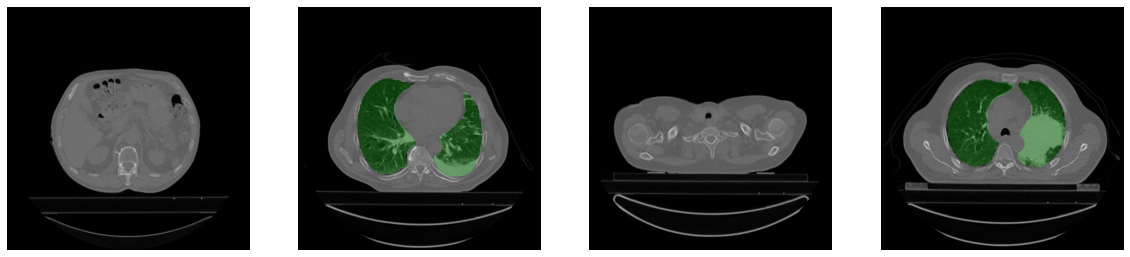

In [4]:
val_ds = NSCLCDataset(metadata_path="data/processed/NSCLC-Radiomics_val_metadata.pkl")
loader = DataLoader(val_ds, batch_size=4, shuffle=True)
X_test, y_test = next(iter(loader))
plot_samples(X_test, y_test, 1, 4, figsize=(20, 20), 
             mask_color=(0, 255, 0),
             mask_alpha=0.2)

In [ ]:
preds = net(X_test.cuda())
pred_masks = torch.argmax(preds, dim=1)
pred_masks = pred_masks.cpu()
plot_samples(X_test.cpu(), pred_masks.cpu(), 1, 4, figsize=(20, 20),
             mask_color=(255, 0, 0),
             mask_alpha=0.2)

In [ ]:
#train_ds = NSCLCDataset(ct_dir="data/raw/NSCLC-Radiomics/",
#                        mask_dir="data/processed/NSCLC_ground_truths/", 
#                        subset="train")
#val_ds = NSCLCDataset(ct_dir="../data/raw/NSCLC-Radiomics/", 
#                      mask_dir="../data/processed/NSCLC_ground_truths/", 
#                      subset="val")
train_ds = NSCLCDataset(metadata_path="data/processed/NSCLC-Radiomics_train_metadata.pkl")
val_ds = NSCLCDataset(metadata_path="data/processed/NSCLC-Radiomics_val_metadata.pkl")

train_sm = Subset(train_ds, range(500))
train_sm_loader = DataLoader(train_sm, batch_size=4,
                                 num_workers=4,
                                 shuffle=True,
                                 #pin_memory=True
                                )
train_loader = DataLoader(train_ds, batch_size=4,
                          num_workers=4,
                          shuffle=True,
                          #pin_memory=True
                         )
val_loader = DataLoader(val_ds, batch_size=4,
                        num_workers=4,
                        shuffle=True,
                        pin_memory=True)

In [ ]:
X_batch, y_batch = next(iter(train_sm_loader))
plot_samples(X_batch, y_batch, nrows=2, ncols=2, figsize=(6,6))

In [ ]:
num_iters = 100

device = "cuda:0"
loss_fn = nn.CrossEntropyLoss()
net = UNet(in_c=1, num_classes=2).to(device)
opt = optim.SGD(net.parameters(), lr=1e-3)

In [ ]:
for i in range(num_iters):
    for i, (X_batch, y_batch) in enumerate(tqdm(val_loader)):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        opt.zero_grad()
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        opt.step()
        if i % 10 == 0:
            print(f"Iter {i}: loss = {loss.item()}")